<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/RmsProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from random import randint
from random import random
from random import seed
import math
from sklearn.utils import shuffle

In [2]:
from keras.datasets import fashion_mnist

In [3]:
train_data,test_data=fashion_mnist.load_data()

In [4]:
train_data_mean = np.mean(train_data[0])
train_data_stdev = np.std(train_data[0])
train_data = ((train_data[0] - train_data_mean) / train_data_stdev, train_data[1])
test_data = ((test_data[0] - train_data_mean) / train_data_stdev, test_data[1])
train_X, trainY = train_data
test_X, testY = test_data

In [5]:
train_X, trainY = shuffle(train_X, trainY)
test_X, testY = shuffle(test_X, testY)

In [6]:
print('Train: X=%s, y=%s' %(train_X.shape,trainY.shape))
print('Test: X=%s, y=%s' %(test_X.shape,testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [7]:
class_label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
sample=[]
for label in range(10):
    for i in range(len(testY)):
        if label==testY[i]:
            sample.append(test_X[i])
            break

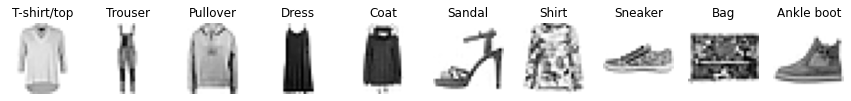

In [9]:
fig=plt.figure(figsize=(15,15))
rows=1
columns=10
for i in range(1, columns*rows +1):
    tg=sample[i-1]
    ax=fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(tg,cmap=plt.cm.binary)
    ax.title.set_text(class_label[i-1])
plt.show()

In [10]:
trainX=[train_X[i].flatten() for i in range(len(train_X))]
print(np.shape(trainX))
print(np.shape(trainY))

(60000, 784)
(60000,)


In [11]:
testX=[test_X[i].flatten() for i in range(len(test_X))]
print(np.shape(testX))
print(np.shape(testY))

(10000, 784)
(10000,)


In [12]:
train_samples=len(trainX)
test_samples=len(testX)
xlen=len(trainX[0])
print(xlen)

784


In [13]:
#No of Layers
L=3
#size of each hidden layer
N=32
#No of classes
K=10

In [14]:
def initialize_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[np.random.normal() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[np.random.normal() for j in range(neurons_hl)]for i in range(n_output)])
    return W

In [15]:
def initialize_bias(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([np.random.normal() for i in range(neurons_hl)])
    B.append([np.random.normal() for i in range(n_output)])
    return B

In [16]:
def sigmoid(b):
  a=np.array(b,dtype=np.float128)
  h=list()
  for el in a:
    h.append(1/(1+np.exp(-el)))
  return h

In [17]:
def softmax(b):
  a=np.array(b,dtype=np.float128)
  z = a - max(a)
  h=list()
  sum=0
  for el in z:
    sum+=np.exp(el)
  for el in z:
    h.append(np.exp(el)/sum)
  return h

In [18]:
def feed_forward(input,W,B,L):
    H=list()
    A=list()
    H.append(input)
    A.append([0])
    for i in range(1,L):
        a=B[i-1]+np.matmul(W[i-1],H[i-1])
        A.append(a)
        H.append(sigmoid(a))
    a=B[L-1]+np.matmul(W[L-1],H[L-1])
    A.append(a)
    hL=softmax(a)
    H.append(hL)
    return H,A,hL

In [19]:
def cmp(e):
  g=1/(1+np.exp(-e))
  return g*(1-g)

In [20]:
def diff_sigmoid(a):
    res=list()
    for el in a:
      res.append(cmp(el))
    return res

In [21]:
def back_propogation(H,A,y_hat,label,W):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff_sigmoid(A[k-1]))
    return W_grad,B_grad

In [22]:
eta=0.0001

In [23]:
def rmsprop():
    t=0
    epoch=5
    batch_size=128
    W= initialize_weights(xlen,L-1,K,N)
    B= initialize_bias(xlen,L-1,K,N)
    loss=list()
    points=0
    error=0.0
    epsilon=1e-10
    beta=0.98
    wgrad=list()
    bgrad=list()
    for l in range(L):
        wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
        bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
    v_w=list()
    v_b=list()
    for l in range(L):
        v_w.append(np.zeros(shape=np.shape(W[l])).tolist())
        v_b.append(np.zeros(shape=np.shape(B[l])).tolist())
    while (t<epoch):
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L)
            error+=(-math.log(y_hat[trainY[i]]))
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i],W)
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                wgrad[l]=(np.matrix(wgrad[l])+np.matrix(W_grad[l])).tolist()
                bgrad[l]=(bgrad[l]+np.multiply(1,B_grad[l])).tolist()
            points+=1
            if(points%batch_size==0):
                points=0
                loss.append(error/batch_size)
                error=0.0
                for l in range(L):
                    v_w[l]=(np.multiply(beta,v_w[l])+np.multiply((1-beta),np.square(wgrad[l]))).tolist()
                    tmp=v_w[l].copy()
                    new_t=np.add(epsilon,tmp).tolist()
                    rl=np.reciprocal([[float(j) for j in i] for i in np.sqrt(new_t)]).tolist()
                    W[l]=(W[l]-np.multiply(wgrad[l],np.multiply(eta,rl))).tolist()
                    v_b[l]=(np.multiply(beta,v_b[l])+np.multiply((1-beta),np.square(bgrad[l]))).tolist()
                    tmp1=v_b[l].copy()
                    new_t1=np.add(epsilon,tmp1).tolist()
                    rl1=np.reciprocal([float(i) for i in np.sqrt(new_t1)]).tolist()
                    B[l]=np.subtract(B[l],np.multiply(bgrad[l],np.multiply(eta,rl1))).tolist()
                wgrad=list()
                bgrad=list()
                for l in range(L):
                    wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
                    bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())            
        t=t+1
        print('Epoch',t)
    return W,B,loss

In [24]:
W_r,B_r,loss=rmsprop()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5


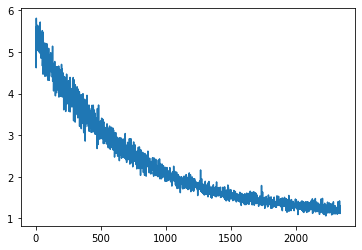

In [25]:
plt.plot(np.arange(1,len(loss)+1),loss)

In [27]:
#Prediction
valid=0
predict=[]
for i in range(test_samples):
    H,A,y_hat = feed_forward(testX[i],W_r,B_r,L)
    class_predict = y_hat.index(max(y_hat))
    predict.append(class_predict)
    if(class_predict==testY[i]):
      valid+=1

In [28]:
valid

6138